<a href="https://colab.research.google.com/github/stevenliu216/rob535-perception-project/blob/master/colab/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## First section is for training

In [0]:
# https://www.marktechpost.com/2019/06/07/how-to-connect-google-colab-with-google-drive/
from google.colab import files
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/My\ Drive/kaggle_data
!unzip /content/gdrive/My\ Drive/kaggle_data/py_train.zip

predictions2.csv	   resnetCars.pt
predictions3.csv	   rob535-fall-2019-task-1-image-classification.zip
predictions4.csv	   team10_trained_inceptionv3.pt
predictions5.csv	   team10_trained_resnet_2.pt
predictions6.csv	   team10_trained_resnet_3.pt
predictions7.csv	   team10_trained_resnet_5.pt
predictions.csv		   team10_trained_resnet.pt
predictions_resnext_2.csv  team10_trained_resnext_epoch5.pt
predictions_resnext.csv    team10_trained_resnext.pt
py_train.zip
Archive:  /content/gdrive/My Drive/kaggle_data/py_train.zip
   creating: py_train/
   creating: py_train/0/
  inflating: py_train/0/e45b8b68-3576-4450-b042-6f10d27451b70044.jpg  
  inflating: py_train/0/e45b8b68-3576-4450-b042-6f10d27451b70050.jpg  
  inflating: py_train/0/abd0019d-44ca-4985-aa27-599ab1d44aad0002.jpg  
  inflating: py_train/0/39b63f49-5eae-465c-8dd4-a1ada0b831630001.jpg  
  inflating: py_train/0/d1d539c2-8321-45d9-868a-fd8544e0ce010086.jpg  
  inflating: py_train/0/d1d539c2-8321-45d9-868a-fd8544e0ce010092.jpg  
 

In [4]:
!ls /content/gdrive/My\ Drive/kaggle_data
!unzip /content/gdrive/My\ Drive/kaggle_data/rob535-fall-2019-task-1-image-classification.zip

predictions2.csv	   resnetCars.pt
predictions3.csv	   rob535-fall-2019-task-1-image-classification.zip
predictions4.csv	   team10_trained_inceptionv3.pt
predictions5.csv	   team10_trained_resnet_2.pt
predictions6.csv	   team10_trained_resnet_3.pt
predictions7.csv	   team10_trained_resnet_5.pt
predictions.csv		   team10_trained_resnet.pt
predictions_resnext_2.csv  team10_trained_resnext_epoch5.pt
predictions_resnext.csv    team10_trained_resnext.pt
py_train.zip
Archive:  /content/gdrive/My Drive/kaggle_data/rob535-fall-2019-task-1-image-classification.zip
warning [/content/gdrive/My Drive/kaggle_data/rob535-fall-2019-task-1-image-classification.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
   creating: rob535-fall-2019-task-1-image-classification/
   creating: rob535-fall-2019-task-1-image-classification/data-2019/
  inflating: rob535-fall-2019-tas

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torchvision import datasets, transforms, models
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import *

import time
import json
import copy
import os

from PIL import Image
from collections import OrderedDict

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available.')

CUDA is available.


In [0]:
# Tansform with data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        #transforms.RandomResizedCrop(224), # Dont want to crop 
        transforms.Resize((224,224)),
        #transforms.RandomResizedCrop(299),  #size for inception architecture
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        #transforms.Resize(256),
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        #transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((224,224)),   
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        #transforms.RandomResizedCrop(224), # Dont want to crop 
        transforms.Resize((299,299)),
        #transforms.RandomResizedCrop(299),  #size for inception architecture
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        #transforms.Resize(256),
        transforms.Resize((299,299)),
        #transforms.CenterCrop(224),
        #transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((299,299)),   
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}

In [7]:
#Loading in the dataset

train_dir = 'py_train'
test_dir = 'py_test'
label_dir = 'labels.csv'

batch_size=32
dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])

# splitting our data
valid_size  = int(0.1 * len(dataset))
train_size = len(dataset) - valid_size
dataset_sizes = {'train': train_size, 'valid': valid_size}

# now we get our datasets
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

# Loading datasets into dataloader 
dataloaders = {'train': DataLoader(train_dataset, batch_size = batch_size, shuffle = True),
              'valid': DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)}

print("Total Number of Samples: ",len(dataset))
print("Number of Samples in Train: ",len(train_dataset))
print("Number of Samples in Valid: ",len(valid_dataset))
print("Number of Classes: ",len(dataset.classes))

print(dataset.classes)

Total Number of Samples:  5561
Number of Samples in Train:  5005
Number of Samples in Valid:  556
Number of Classes:  4
['0', '1', '2', '3']


In [8]:
names = pd.read_csv('rob535-fall-2019-task-1-image-classification/data-2019/labels.csv')
names.head()

guid/image  label
0  01aaa345-52ad-4939-8207-2d39c11acfdc/0000      0
1  01aaa345-52ad-4939-8207-2d39c11acfdc/0001      1
2  01aaa345-52ad-4939-8207-2d39c11acfdc/0002      0
3  01aaa345-52ad-4939-8207-2d39c11acfdc/0003      1
4  01aaa345-52ad-4939-8207-2d39c11acfdc/0004      1

 Sizes of Datasets:  556 5005


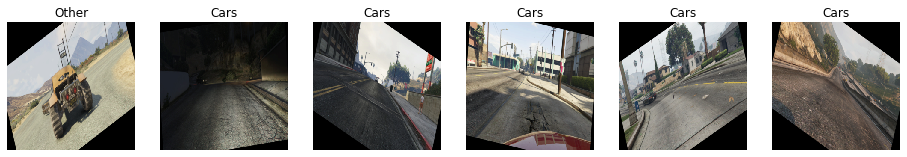

In [9]:
## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


print(" Sizes of Datasets: ", len(valid_dataset), len(train_dataset))
# Displaying Training Images
images, labels = next(iter(dataloaders['train']))
class_names = ['None', 'Cars', 'Commercial', 'Other']
fig, axes = plt.subplots(figsize=(16,5), ncols=6)
for ii in range(6):
    ax = axes[ii]
    ax.set_title(class_names[labels[ii].item()])
    imshow(images[ii], ax=ax, normalize=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'resnext' #vgg
# Densenet
if model_name == 'densenet':
    model = models.densenet161(pretrained=True)
    num_in_features = 2208
    print(model)
# VGGNet
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)
# Resnet
elif model_name == 'resnet':
    #model = models.resnet152(pretrained=True) 
    model = models.resnet34(pretrained=True)
    num_in_features = 512 # 2048 #
    print(model.fc)
# Inception
elif model_name == 'inception':
  model = models.inception_v3(pretrained=True)
  model.aux_logits=False
  num_in_features = 2048
  print(model.fc)
elif model_name == 'resnext':
  model = models.resnext50_32x4d(pretrained=True)
  num_in_features = 2048
else:
    print("Unknown model, please choose 'densenet' or 'vgg'")

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 105MB/s] 


In [0]:
# Freezing parameters
for param in model.parameters():
    param.require_grad = False
  
# Create Custom Classifier
def build_classifier(num_in_features, hidden_layers, num_out_features):
    classifier = nn.Sequential()
    # when we don't have any hidden layers
    if hidden_layers == None:      
        classifier.add_module('fc0', nn.Linear(num_in_features, len(dataset.classes)))    # Change 196 to 4 (4 classes in our dataset)
    #when we have hidden layers
    else:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.6))
        
        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))
        
    return classifier

In [12]:
#define our hidden layers
hidden_layers = [1000] #None
classifier = build_classifier(num_in_features, hidden_layers, 4)
print(classifier)
 # Defining model hyperparameters
if model_name == 'densenet':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters()) # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
   # Decay Learning Rate by a factor of 0.1 every 4 epochs
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)
elif model_name == 'vgg':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
elif model_name == 'resnet':
  model.fc = classifier
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
elif model_name == 'inception':
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
    sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
elif model_name == 'resnext':
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
else:
    pass

Sequential(
  (fc0): Linear(in_features=2048, out_features=1000, bias=True)
  (relu0): ReLU()
  (drop0): Dropout(p=0.6, inplace=False)
  (output): Linear(in_features=1000, out_features=4, bias=True)
)


In [13]:
from torchsummary import summary
summary(model.cuda(), (3,299,299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5          [-1, 128, 75, 75]           8,192
       BatchNorm2d-6          [-1, 128, 75, 75]             256
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]           4,608
       BatchNorm2d-9          [-1, 128, 75, 75]             256
             ReLU-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]          32,768
      BatchNorm2d-12          [-1, 256, 75, 75]             512
           Conv2d-13          [-1, 256, 75, 75]          16,384
      BatchNorm2d-14          [-1, 256,

In [0]:
# Training 
def train_model(model, criterion, optimizer, sched, num_epochs=5,device='cuda'):
    start = time.time()
    train_results = []
    valid_results = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':            
              model.train()  # Set model to training mode
            else:
              model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #sched.step()
                        loss.backward()
                        
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if(phase == 'train'):
              train_results.append([epoch_loss,epoch_acc])
            if(phase == 'valid'):
              valid_results.append([epoch_loss,epoch_acc])
                                   
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model (Early Stopping) and Saving our model, when we get best accuracy
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())       
                model_save_name = "team10_trained_resnext_10_epochs.pt"
                path = F"/content/gdrive/My Drive/kaggle_data/{model_save_name}"
                torch.save(model.state_dict(), path)        

        print()

    # Calculating time it took for model to train    
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model,train_results,valid_results

In [15]:
epochs = 10
#move model to GPU
model.to(device)
model,train_results,valid_results = train_model(model, criterion, optimizer, sched, epochs)

Epoch 1/10
----------
train Loss: 1.0838 Acc: 0.5029
valid Loss: 0.9011 Acc: 0.6043

Epoch 2/10
----------
train Loss: 0.8412 Acc: 0.6310
valid Loss: 0.6704 Acc: 0.7464

Epoch 3/10
----------
train Loss: 0.6796 Acc: 0.7257
valid Loss: 0.5945 Acc: 0.7572

Epoch 4/10
----------
train Loss: 0.5894 Acc: 0.7726
valid Loss: 0.5546 Acc: 0.7788

Epoch 5/10
----------
train Loss: 0.5194 Acc: 0.8036
valid Loss: 0.5750 Acc: 0.7698

Epoch 6/10
----------


KeyboardInterrupt: ignored

In [0]:
!ls rob535-fall-2019-task-1-image-classification/data-2019/test/testlabels.csv

## **In following section, we will load a previously trained model and evaluate test data with it. Currently, loading in the 'team10_trained_resnext.pt' model.**

In [16]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/kaggle_data/team10_trained_resnext_10_epochs.pt'))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [17]:
from pathlib import Path

# Load the datasets with ImageFolder
#label_df = pd.read_csv('labels.csv', names=["label"])

test_dir = 'rob535-fall-2019-task-1-image-classification/data-2019/test/'

with torch.no_grad():
  print("Predictions on Test Set:")
  model.eval()  
  dataset = datasets.ImageFolder(test_dir,transform=data_transforms['test'])
  
  testloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                             shuffle=False, num_workers=2)
 
  image_names = []
  pred = []
  for index in testloader.dataset.imgs:
    tmp = index[0].replace('rob535-fall-2019-task-1-image-classification/data-2019/test/','')
    tmp = tmp.replace('_image.jpg', '')
    image_names.append(Path(tmp))
    
    
  results = []
  file_names = []
  predicted_car = []
  predicted_class = []

  for inputs,labels in testloader:
    inputs = inputs.to(device)
    #labels = labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs, 1) 
    
    for i in range(len(inputs)):
      file_names.append(image_names[i])
      #predicted_car.append(int(pred[i] + 1))
      # Is there an off-by-1 error?
      predicted_car.append(int(pred[i]))
      
results.append((file_names, predicted_car))

Predictions on Test Set:


In [18]:
print("Predictions on Test Set:")
df = pd.DataFrame({'guid/image': image_names, 'label': results[0][1]})
pd.set_option('display.max_colwidth', -1)
df

Predictions on Test Set:


guid/image  label
0     0213ada8-e776-4404-9312-c264153c57c1/0000  2    
1     0213ada8-e776-4404-9312-c264153c57c1/0001  2    
2     0213ada8-e776-4404-9312-c264153c57c1/0002  2    
3     0213ada8-e776-4404-9312-c264153c57c1/0003  2    
4     0213ada8-e776-4404-9312-c264153c57c1/0004  2    
...                                         ... ..    
1794  fdf23cc5-6850-4507-996e-3e75cec90b5f/0039  1    
1795  fdf23cc5-6850-4507-996e-3e75cec90b5f/0040  1    
1796  fdf23cc5-6850-4507-996e-3e75cec90b5f/0041  1    
1797  fdf23cc5-6850-4507-996e-3e75cec90b5f/0042  1    
1798  fdf23cc5-6850-4507-996e-3e75cec90b5f/0043  2    

[1799 rows x 2 columns]

In [19]:
df = df.sort_values(by=['guid/image'])
df

guid/image  label
0     0213ada8-e776-4404-9312-c264153c57c1/0000  2    
1     0213ada8-e776-4404-9312-c264153c57c1/0001  2    
2     0213ada8-e776-4404-9312-c264153c57c1/0002  2    
3     0213ada8-e776-4404-9312-c264153c57c1/0003  2    
4     0213ada8-e776-4404-9312-c264153c57c1/0004  2    
...                                         ... ..    
1794  fdf23cc5-6850-4507-996e-3e75cec90b5f/0039  1    
1795  fdf23cc5-6850-4507-996e-3e75cec90b5f/0040  1    
1796  fdf23cc5-6850-4507-996e-3e75cec90b5f/0041  1    
1797  fdf23cc5-6850-4507-996e-3e75cec90b5f/0042  1    
1798  fdf23cc5-6850-4507-996e-3e75cec90b5f/0043  2    

[1799 rows x 2 columns]

In [0]:
df.to_csv('/content/gdrive/My Drive/kaggle_data/predictions.csv', index=False)

In [21]:
!ls /content/gdrive/My\ Drive/kaggle_data

predictions2.csv	   resnetCars.pt
predictions3.csv	   rob535-fall-2019-task-1-image-classification.zip
predictions4.csv	   team10_trained_inceptionv3.pt
predictions5.csv	   team10_trained_resnet_2.pt
predictions6.csv	   team10_trained_resnet_3.pt
predictions7.csv	   team10_trained_resnet_5.pt
predictions.csv		   team10_trained_resnet.pt
predictions_resnext_2.csv  team10_trained_resnext_10_epochs.pt
predictions_resnext.csv    team10_trained_resnext_epoch5.pt
py_train.zip		   team10_trained_resnext.pt
